![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)

----

# Experiment: Time-Based Split

----

## Overview (BLUF)

**Bottom line:** When we train on **earlier transactions** and test on **later transactions**, model performance drops sharply compared to the random split.  
Patterns that look very predictive in the random i.i.d. setting **do not transfer cleanly forward in time**.

In this experiment, we force a **past → future** setup:

- Train/validate on address features built only from transactions **before** a time cutoff
- Test on address features built only from transactions **on or after** that cutoff
- Engineer features separately for the past and future windows, using a **shared time origin** and **no future leakage** (an address can appear in both splits, but never with overlapping time).

This notebook asks:

- Can a model trained on **older scams** still recognize **newer scams**?
- How much does **concept drift** (changes in scam behavior over time) hurt performance?
- Does this time-based setup support using the model as a **forward-looking fraud detector**, not just a pattern memorizer?

The result:  
- Under a random split, the tuned XGBoost model behaves like a **high-precision, high-recall filter** (AP ≈ 0.79, precision ≈ 0.79, recall ≈ 0.68 at the chosen threshold).  
- Under the time-based split, the same modeling pipeline yields **much weaker lift** (AP ≈ 0.54): precision can still be very high, but recall collapses (≈ 0.25 at a 0.91-precision threshold).

This notebook is about **temporal robustness**:  
It shows that in this synthetic Ethereum world, fraud patterns **evolve enough over time** that a model trained on older data cannot simply be trusted to catch future scams at the same level as in the random-split experiment.

## 0. Notebook Setup

This section configures autoreload, imports core libraries, and connects the shared `src/` utilities so the rest of the notebook stays clean and focused.

In [1]:
# Enable autoreload so edits to src/*.py modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2

# Make the project root importable so we can use src.utilities, src.featureeng, etc.
import os
import sys
sys.path.append(os.path.abspath(".."))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Project-specific utilities / modeling pipeline
import src.utilities as util
import src.featureeng as fe
import src.model_eval as me
from src import baselines
from src import tuning
from src.seed_util import SEED

from sklearn.model_selection import train_test_split

# Consistent plotting style
sns.set_style("whitegrid")

In [2]:
# ------------------------------------------------------------
# Load the raw Ethereum transaction dataset
#    (util.load_raw_data handles the path + basic logging)
# ------------------------------------------------------------
df = util.load_raw_data()


Loading Dataset

Reading dataset from (CSV): /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/Dataset.csv
Dataset loaded successfully with 71,250 rows and 18 columns.


## 1. Time-Aware Address Labels and Past→Future Split

In this section we:

1. Normalize transaction timestamps and build a **global scam label** per address.  
2. Choose a **time cutoff** and split transactions into **Past** (Train+Val) and **Future** (Test).  
3. Define address pools where:
   - Train+Val addresses have **at least one past transaction**  
   - Test addresses have **at least one future transaction**  
   - An address is allowed to appear in **both** pools — matching an **account-monitoring** setup where we keep watching the same entities over time.
4. Build separate **transaction universes** for the past and future windows and run sanity checks (row counts, label coverage, no orphaned transactions).

This gives us a clean **past→future** framing without forcing entity disjointness, so the models answer:
> *“Given what we learned from early history, how well can we flag scams when time moves forward?”*

In [3]:
# ------------------------------------------------------------
# 1. Address-Level Labels and Time-Aware Split (Addresses May Overlap)
# ------------------------------------------------------------
util.print_heading("Address-Level Labels and Time-Aware Split")

# Normalize timestamps and add block_timestamp_dt, hour, weekday, etc.
df = fe.normalize_timestamps(df, verbose=True)

# Build a single global Scam label per address
addr_df = fe.build_address_labels(df, verbose=True)

# ------------------------------------------------------------
# 2. Define time-based Past vs Future windows
# ------------------------------------------------------------
util.print_sub_heading("Defining Past vs Future Windows")

CUTOFF_Q = 0.80
CUTOFF = df["block_timestamp_dt"].quantile(CUTOFF_Q)
print(f"Time cutoff for train vs test (q={CUTOFF_Q}): {CUTOFF}")

df_past   = df[df["block_timestamp_dt"] <  CUTOFF].copy()
df_future = df[df["block_timestamp_dt"] >= CUTOFF].copy()

print("Past rows:", len(df_past))
print("Future rows:", len(df_future))

# ------------------------------------------------------------
# 3. Address pools for Train+Val (past) and Test (future)
#    (addresses may appear in both: account-monitoring view)
# ------------------------------------------------------------

# Addresses with at least one transaction BEFORE cutoff
past_addrs = pd.Index(
    pd.concat([df_past["from_address"], df_past["to_address"]])
).dropna().unique()

addr_df_past = addr_df[addr_df["Address"].isin(past_addrs)].copy()
print("Addresses with at least one past tx:", len(addr_df_past))
print("Past scam rate (all past-eligible addresses):", addr_df_past["Scam"].mean())

# Entity-level Train/Val split WITHIN the past window
trainval_addrs, _ = train_test_split(
    addr_df_past["Address"],
    test_size=0.2,          # same relative size as random split
    stratify=addr_df_past["Scam"],
    random_state=SEED,
)

print("Train+Val addresses (past window):", len(trainval_addrs))

# Test addresses: any address active ON/AFTER cutoff
future_addrs = pd.Index(
    pd.concat([df_future["from_address"], df_future["to_address"]])
).dropna().unique()

test_addrs = future_addrs
print("Test addresses (future window):", len(test_addrs))

# How many addresses appear in both past and future?
overlap_addrs = set(trainval_addrs) & set(test_addrs)
print("Address overlap (seen in both past and future):", len(overlap_addrs))

# ------------------------------------------------------------
# 3a. Label sanity checks: make sure we have scams in both splits
# ------------------------------------------------------------
addr_df_past_idx = addr_df_past.set_index("Address")
trainval_labels = addr_df_past_idx.loc[trainval_addrs, "Scam"].astype(int)

print("Train+Val positives:", int(trainval_labels.sum()))
print("Train+Val negatives:", int((trainval_labels == 0).sum()))

addr_df_future = addr_df[addr_df["Address"].isin(test_addrs)].copy()
test_labels = addr_df_future["Scam"].astype(int)

print("Test addresses with labels:", len(addr_df_future))
print("Test scam rate:", test_labels.mean())
print("Test positives:", int(test_labels.sum()))
print("Test negatives:", int((test_labels == 0).sum()))

if trainval_labels.sum() == 0 or test_labels.sum() == 0:
    raise ValueError(
        "No scam examples in one of the splits. "
        "Try adjusting CUTOFF_Q or revisiting the time window."
    )

# ------------------------------------------------------------
# 4. Build raw transaction universes (time-disjoint)
# ------------------------------------------------------------

raw_trainval = df_past[
    df_past["from_address"].isin(trainval_addrs)
    | df_past["to_address"].isin(trainval_addrs)
].copy()

raw_test = df_future[
    df_future["from_address"].isin(test_addrs)
    | df_future["to_address"].isin(test_addrs)
].copy()

print("Raw Train+Val tx rows (past):", len(raw_trainval))
print("Raw Test tx rows (future):   ", len(raw_test))

# ------------------------------------------------------------
# 5. Sanity checks: each tx is aligned with its address pool
# ------------------------------------------------------------

train_set = set(trainval_addrs)
test_set  = set(test_addrs)

# Transactions that do not touch any address from the expected pool
orphan_train_rows = raw_trainval[
    (~raw_trainval["from_address"].isin(train_set)) &
    (~raw_trainval["to_address"].isin(train_set))
]
orphan_test_rows = raw_test[
    (~raw_test["from_address"].isin(test_set)) &
    (~raw_test["to_address"].isin(test_set))
]

print("Train+Val rows without a Train+Val address:", len(orphan_train_rows))
print("Test rows without a Test address:", len(orphan_test_rows))

assert len(orphan_train_rows) == 0, "Found tx in raw_trainval with no Train+Val address"
assert len(orphan_test_rows) == 0,  "Found tx in raw_test with no Test address"


Address-Level Labels and Time-Aware Split


----------------------------------------
Timestamp normalization
----------------------------------------

Converting `block_timestamp` into a consistent UTC datetime and adding derived features (hour, weekday).
Value types in timestamp column:
block_timestamp
<class 'str'>    71250
Name: count, dtype: int64
Number of missing raw timestamp values: 0
Parsed timestamps (non-null): 71250
Unparseable timestamps: 0

----------------------------------------
Building Address-Level Scam Labels
----------------------------------------

Total addresses: 73034
Total scam addresses: 169

----------------------------------------
Defining Past vs Future Windows
----------------------------------------

Time cutoff for train vs test (q=0.8): 2018-03-28 07:15:08.400000+00:00
Past rows: 57000
Future rows: 14250
Addresses with at least one past tx: 66603
Past scam rate (all past-eligible addresses): 0.0010510037085416572
Train+Val addresses (past window): 532

### Time-Split Diagnostics

From this split:

- **Train+Val (past window):**
  - 53,282 addresses
  - 56 scams (scam rate ≈ 0.11%)

- **Test (future window):**
  - 7,047 addresses
  - 124 scams (scam rate ≈ 1.76%)

- **Address overlap between past and future:** 486

So we train on a **sparse trickle of early scams** and evaluate on a future slice where scams are **more common and partially overlapping in identity**. Any collapse in performance relative to the random split is evidence that **fraud patterns and base rates change over time**, not that the pipeline itself is broken.

## 2. Time-Based Address Features (Past vs Future)

With the past→future split defined, we now build **address-level features separately** for:

- **Train+Val (Past):** features derived only from transactions **before** the cutoff  
- **Test (Future):** features derived only from transactions **on/after** the cutoff  

Both splits share a single **global time origin** (`global_start`), so duration-like features (e.g., time since first seen) are comparable across past and future, but:

- No future transactions are used to compute past features  
- No past transactions are used to compute future features  

This ensures there is **no time leakage**: the model only sees information that would have been available **at that point in history** when predicting on the future window.

In [4]:
util.print_heading("Engineering Address-Level Features for Past and Future (No Time Leakage)")

# Global reference start time for all temporal features
global_start = df["block_timestamp_dt"].min()
if pd.isna(global_start):
    raise ValueError("Global start timestamp is NaT — check timestamp parsing.")
print("Global start timestamp:", global_start)

# ------------------------------------------------------------
# Train+Val features (past transactions only)
# ------------------------------------------------------------
features_trainval = fe.engineer_address_features(
    transaction_df=raw_trainval,
    target_addresses=trainval_addrs,
    addr_labels=addr_df,
    global_start=global_start,
    split_label="Train+Val (Past)",
    verbose=True,
)

# ------------------------------------------------------------
# Test features (future transactions only)
# ------------------------------------------------------------
features_test = fe.engineer_address_features(
    transaction_df=raw_test,
    target_addresses=test_addrs,
    addr_labels=addr_df,
    global_start=global_start,
    split_label="Test (Future)",
    verbose=True,
)

# Quick diagnostics
TARGET_COL = "Scam"

print("Train+Val feature table shape:", features_trainval.shape)
print("Test feature table shape:", features_test.shape)

print("Train+Val scam count:", int(features_trainval[TARGET_COL].sum()))
print("Train+Val scam rate:", features_trainval[TARGET_COL].mean())

print("Test scam count:", int(features_test[TARGET_COL].sum()))
print("Test scam rate:", features_test[TARGET_COL].mean())


Engineering Address-Level Features for Past and Future (No Time Leakage)

Global start timestamp: 2017-10-16 05:26:53+00:00

Preparing Transaction Data for Feature Engineering — Train+Val (Past)

Initial row count: 53714

----------------------------------------
Numeric Column Diagnostics
----------------------------------------

value: invalid=0
gas: invalid=0
gas_price: invalid=0
Numeric cleaning complete. Rows retained: 53714

----------------------------------------
Advanced Temporal Behavior Features
----------------------------------------



/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:427: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_metrics = long_advanced.groupby("Address").apply(_compute_time_metrics)
/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:440: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness = long_advanced.groupby("Address").apply(burst)



----------------------------------------
Gas-Based Features
----------------------------------------


Aligning Features to Target Address List


----------------------------------------
Final Feature Table Sample — Train+Val (Past)
----------------------------------------



,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
Address,,,,,,,,,,,,,,,,,,,,,
0xa95f1228b81e3e7a34911431f96c26d55bc286c9,1,0,1,0,1,3.906250e+15,3.906250e+15,3.906250e+15,3.906250e+15,0.000000e+00,...,-0.0,1,0,392064.0,1.000000,2.0,13697248.0,1.000000e+00,21000.0,0
0x4560b34a1899e09569841a416c298f164071430d,1,1,1,1,2,2.040000e+18,2.040000e+18,2.040000e+18,2.040000e+18,3.040000e+18,...,1.0,1,1,10433053.0,0.000007,1.0,3656259.0,8.700000e+10,47500.0,0
0x649e7cf8ccdacf7c3b70e2a537164e95a83fc9c1,0,1,0,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.610000e+18,...,-0.0,0,1,13840998.0,1.000000,0.5,248314.0,1.400000e+10,21000.0,0
0x220b13a56a9bb5d930c6fc5fb9d62ae7c391e49a,0,1,0,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.800000e+19,...,-0.0,0,1,6650185.0,1.000000,0.5,7439127.0,2.100000e+10,21000.0,0
0x5bcf3e31d5fee73ab4c8b5916093e2c42015748a,1,0,1,0,1,1.030000e+17,1.030000e+17,1.030000e+17,1.030000e+17,0.000000e+00,...,-0.0,1,0,9221879.0,1.000000,2.0,4867433.0,1.000000e+11,21000.0,0


Total addresses in this split: 53282
Total scam labels: 56

Preparing Transaction Data for Feature Engineering — Test (Future)

Initial row count: 14250

----------------------------------------
Numeric Column Diagnostics
----------------------------------------

value: invalid=0
gas: invalid=0
gas_price: invalid=0
Numeric cleaning complete. Rows retained: 14250

----------------------------------------
Advanced Temporal Behavior Features
----------------------------------------



/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:427: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_metrics = long_advanced.groupby("Address").apply(_compute_time_metrics)
/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:440: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness = long_advanced.groupby("Address").apply(burst)



----------------------------------------
Gas-Based Features
----------------------------------------


Aligning Features to Target Address List


----------------------------------------
Final Feature Table Sample — Test (Future)
----------------------------------------



,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0,40,0,17,40,0.0,0.0,0.0,0.0,6.627718e+18,...,3.836280,0,40,52103991.0,0.000001,0.024390,17475416.0,4.637328e+10,40000.0,0
0xdadae7756cb168b53b9301fead0b2b80c6a34ff0,0,1,0,1,1,0.0,0.0,0.0,0.0,1.830000e+17,...,-0.000000,0,1,14092457.0,1.000000,0.500000,55486950.0,1.150000e+10,21000.0,0
0x9f32e47acc61432a24ad42ecc30dc73ac2f9d225,0,1,0,1,1,0.0,0.0,0.0,0.0,5.000000e+15,...,-0.000000,0,1,14092485.0,1.000000,0.500000,55486922.0,3.500000e+10,21000.0,0
0x0fd081e3bb178dc45c0cb23202069dda57064258,0,18,0,18,18,0.0,0.0,0.0,0.0,7.349333e+18,...,3.149673,0,18,14301905.0,0.000086,0.052632,55277502.0,1.020000e+11,21000.0,0
0x22b84d5ffea8b801c0422afe752377a64aa738c2,0,91,0,89,91,0.0,0.0,0.0,0.0,2.130824e+19,...,3.962212,0,91,14317682.0,0.000404,0.010870,55261725.0,9.100000e+10,100000.0,0


Total addresses in this split: 7047
Total scam labels: 124
Train+Val feature table shape: (53282, 32)
Test feature table shape: (7047, 32)
Train+Val scam count: 56
Train+Val scam rate: 0.0010510115986637138
Test scam count: 124
Test scam rate: 0.017596140201504185


## 3. Persist Time-Split Feature Tables

To keep this experiment reproducible and decoupled from upstream notebooks,  
we save the engineered features for the **past (Train+Val)** and **future (Test)** windows.

In [5]:
# ------------------------------------------------------------
# Save Time-Split Feature Tables to disk
# ------------------------------------------------------------
features_trainval_name = "time_split_trainval"
features_test_name     = "time_split_test"

util.save_data(features_trainval, features_trainval_name, index=True)
util.save_data(features_test,     features_test_name,     index=True)


Saving Dataset

Writing CSV dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/time_split_trainval.csv
CSV saved with 53,282 rows and 32 columns.
Writing Parquet dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/time_split_trainval.parquet
Parquet saved.

Saving Dataset

Writing CSV dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/time_split_test.csv
CSV saved with 7,047 rows and 32 columns.
Writing Parquet dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/time_split_test.parquet
Parquet saved.


## 4. Baseline Models — Time-Based Split

With time-aware Train+Val and Test feature tables in place, we now reuse the **same baseline pipeline** as in the random-split experiment:

- Same models (LogisticRegression, RandomForest, ExtraTrees, XGBoost)
- Same target column (`Scam`)
- Same evaluation logic and metrics

The **only difference** is the data split:

- Here, Train+Val is restricted to **past transactions**,  
- Test comes from **future transactions**,  
- Some addresses appear in both windows (account-monitoring view).

Any drop in performance relative to the random-split notebook is therefore due to **temporal drift**, not a change in model setup.


Baseline Models — Time-Based Split


Train / Validation Split (Within Train+Val Addresses)

Train+Val shape: (53282, 31)
Test shape:      (7047, 31)
Train+Val positives: 56
Train+Val negatives: 53226
Test positives:       124
Test negatives:       6923

Train size: 42625
Val size:   10657
Test size:  7047

Scaling Numeric Features (for Linear/NN Models)


Defining Baseline Models

XGBoost baseline defined.

Running Baseline Models


----------------------------------------
Fitting LogisticRegression
----------------------------------------

Scoring on Train / Val / Test...
LogisticRegression — Validation metrics:
  val_accuracy: 0.9683
  val_precision: 0.0233
  val_recall: 0.7273
  val_f1: 0.0452
  val_roc_auc: 0.7999
  val_avg_precision: 0.1115
Confusion matrix (val):
[[10311   335]
 [    3     8]]


Full Evaluation — LogisticRegression (Test Split)


=== Evaluation for: LogisticRegression — Test ===
threshold = 0.5
Accuracy:  0.2868
Precision: 0.0222
Recall:    0.9194
F1:        0.0

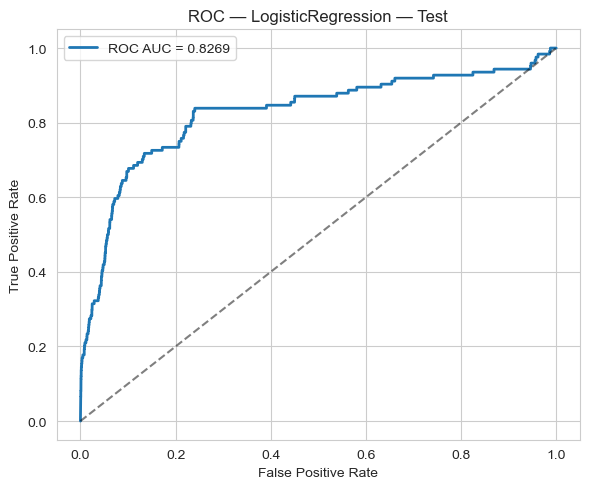

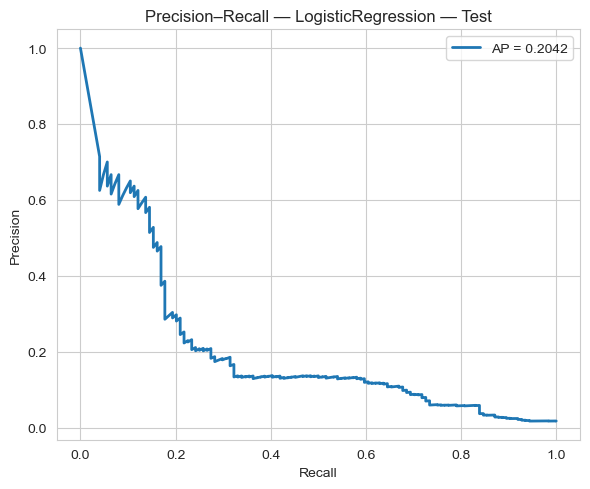

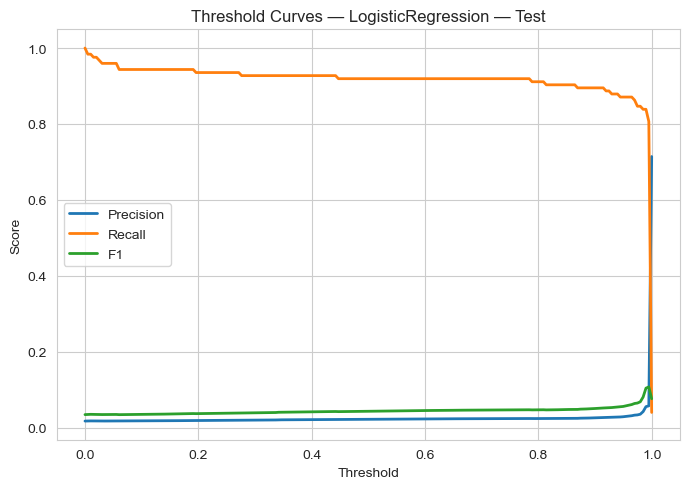

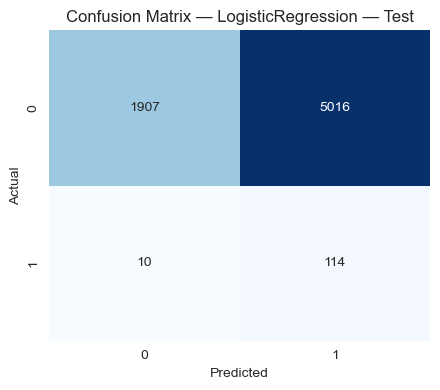

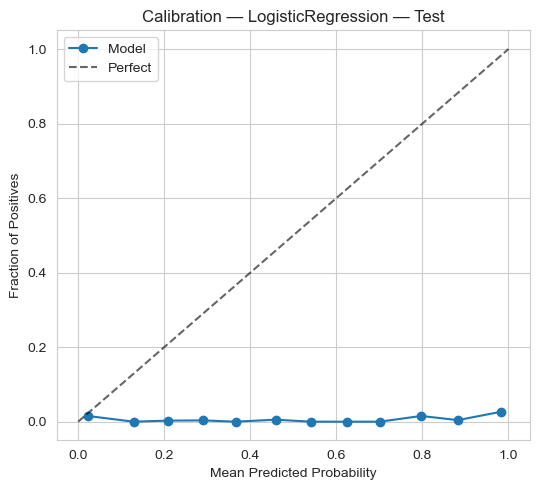


----------------------------------------
Fitting RandomForest
----------------------------------------

Scoring on Train / Val / Test...
RandomForest — Validation metrics:
  val_accuracy: 0.9992
  val_precision: 1.0000
  val_recall: 0.1818
  val_f1: 0.3077
  val_roc_auc: 0.8601
  val_avg_precision: 0.4473
Confusion matrix (val):
[[10646     0]
 [    9     2]]


Full Evaluation — RandomForest (Test Split)


=== Evaluation for: RandomForest — Test ===
threshold = 0.5
Accuracy:  0.9824
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
ROC AUC:   0.5472
Avg Precision (AP): 0.3080


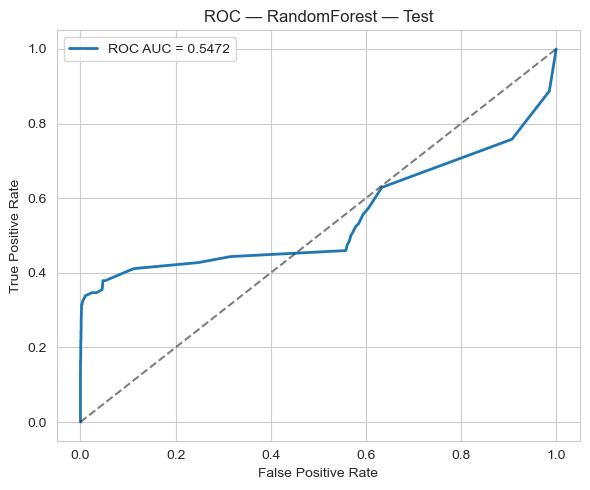

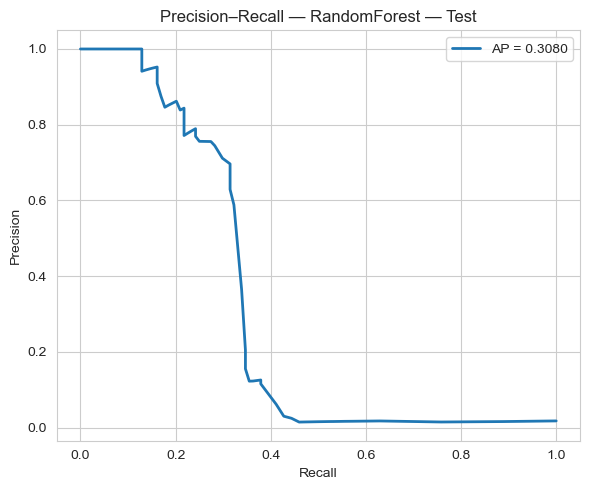

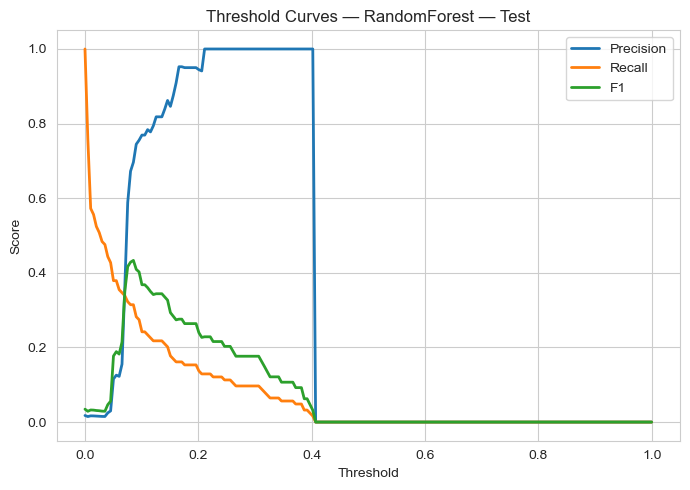

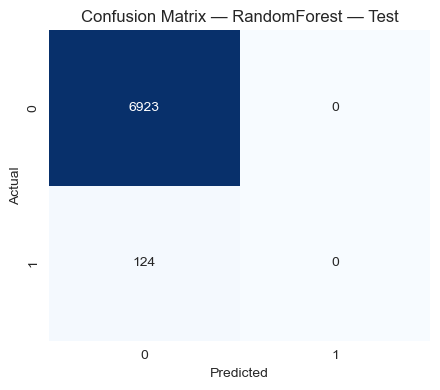

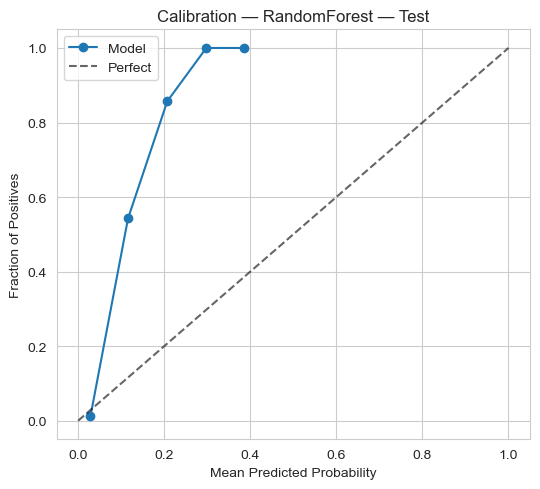


----------------------------------------
Fitting ExtraTrees
----------------------------------------

Scoring on Train / Val / Test...
ExtraTrees — Validation metrics:
  val_accuracy: 0.9991
  val_precision: 1.0000
  val_recall: 0.0909
  val_f1: 0.1667
  val_roc_auc: 0.9041
  val_avg_precision: 0.4030
Confusion matrix (val):
[[10646     0]
 [   10     1]]


Full Evaluation — ExtraTrees (Test Split)


=== Evaluation for: ExtraTrees — Test ===
threshold = 0.5
Accuracy:  0.9831
Precision: 1.0000
Recall:    0.0403
F1:        0.0775
ROC AUC:   0.9263
Avg Precision (AP): 0.3992


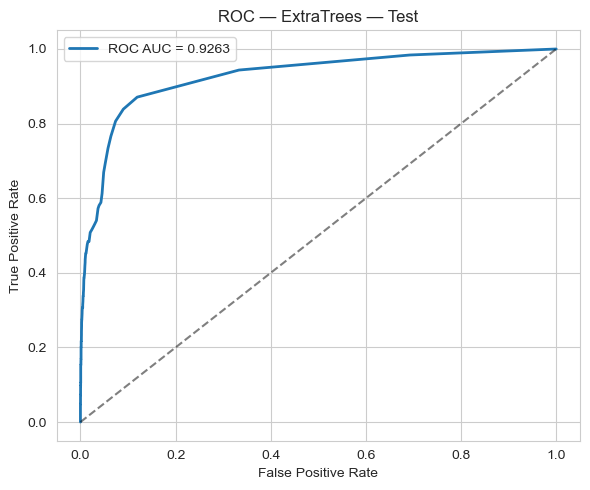

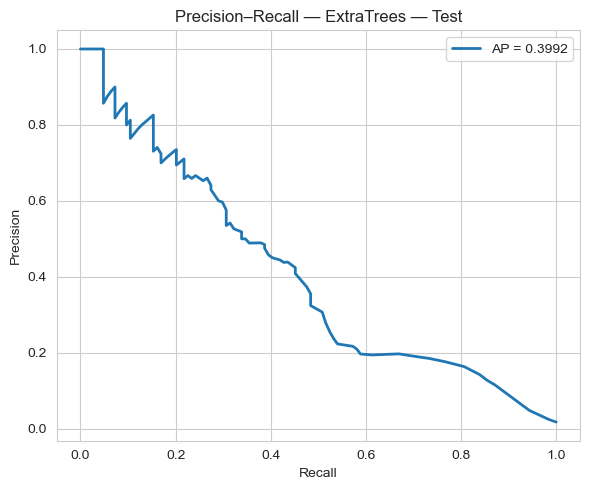

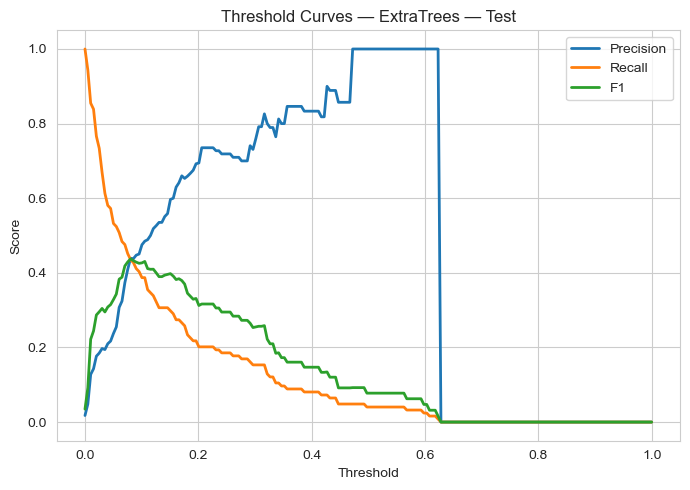

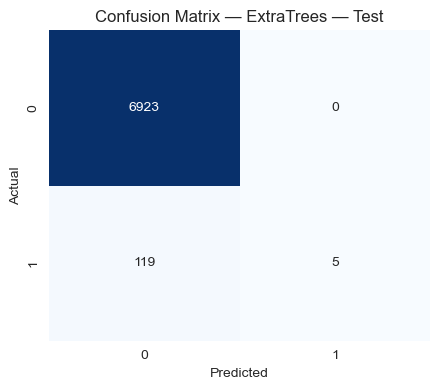

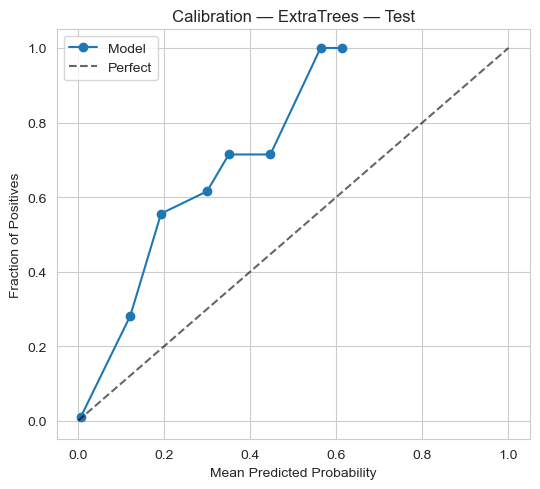


----------------------------------------
Fitting XGBoost
----------------------------------------

Scoring on Train / Val / Test...
XGBoost — Validation metrics:
  val_accuracy: 0.9988
  val_precision: 0.4167
  val_recall: 0.4545
  val_f1: 0.4348
  val_roc_auc: 0.9033
  val_avg_precision: 0.4327
Confusion matrix (val):
[[10639     7]
 [    6     5]]


Full Evaluation — XGBoost (Test Split)


=== Evaluation for: XGBoost — Test ===
threshold = 0.5
Accuracy:  0.9865
Precision: 0.8372
Recall:    0.2903
F1:        0.4311
ROC AUC:   0.9035
Avg Precision (AP): 0.4583


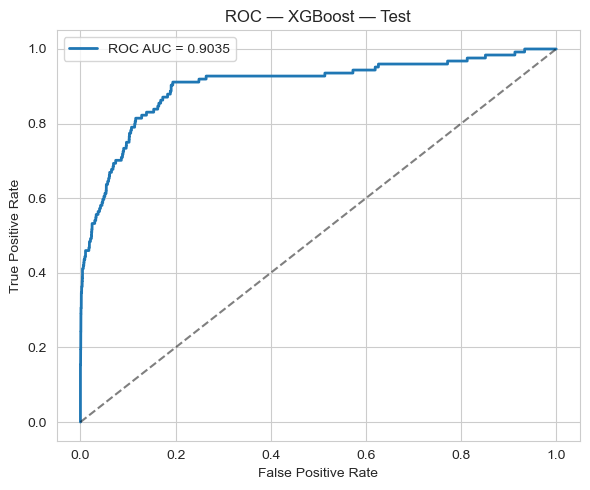

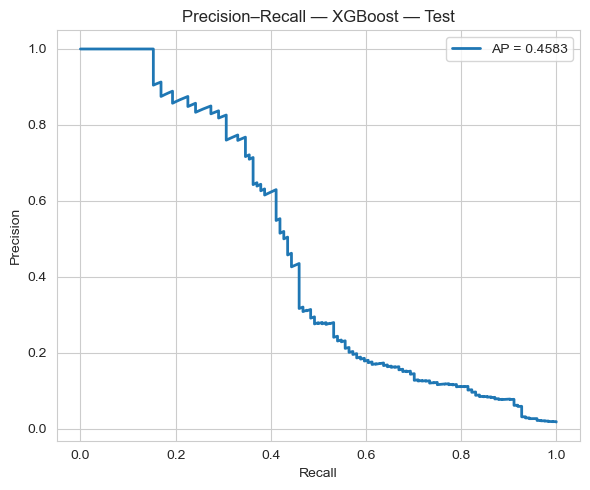

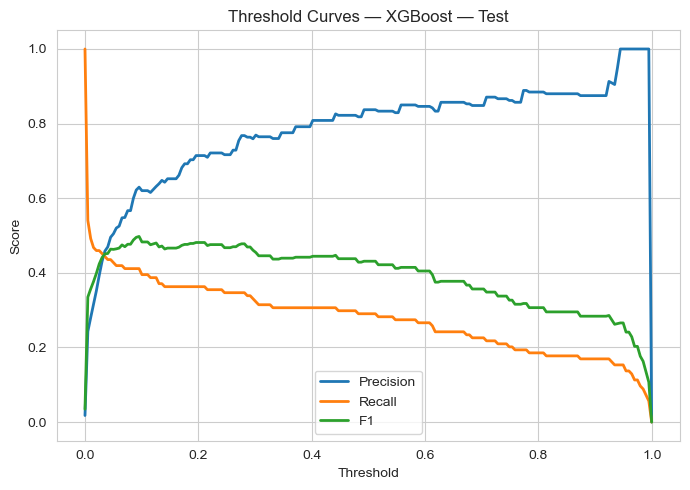

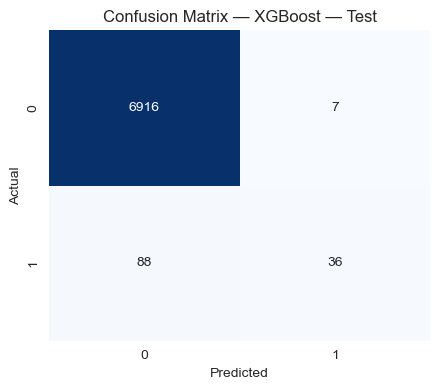

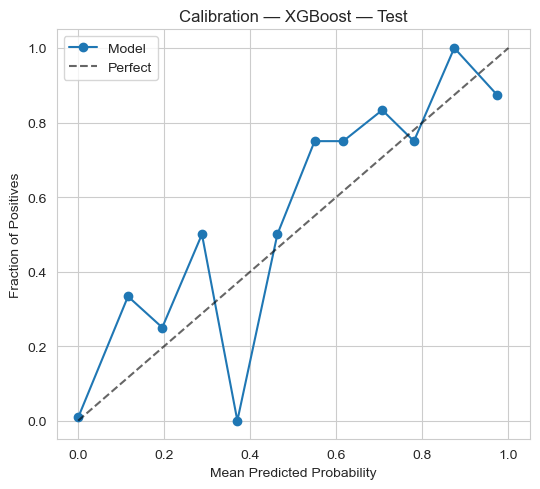


----------------------------------------
Fitting MLP
----------------------------------------

Scoring on Train / Val / Test...
MLP — Validation metrics:
  val_accuracy: 0.9991
  val_precision: 0.6000
  val_recall: 0.2727
  val_f1: 0.3750
  val_roc_auc: 0.7616
  val_avg_precision: 0.3335
Confusion matrix (val):
[[10644     2]
 [    8     3]]


Full Evaluation — MLP (Test Split)


=== Evaluation for: MLP — Test ===
threshold = 0.5
Accuracy:  0.9827
Precision: 1.0000
Recall:    0.0161
F1:        0.0317
ROC AUC:   0.8947
Avg Precision (AP): 0.3934


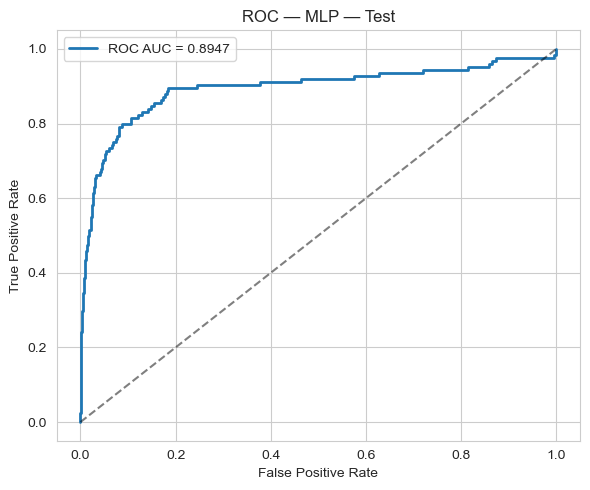

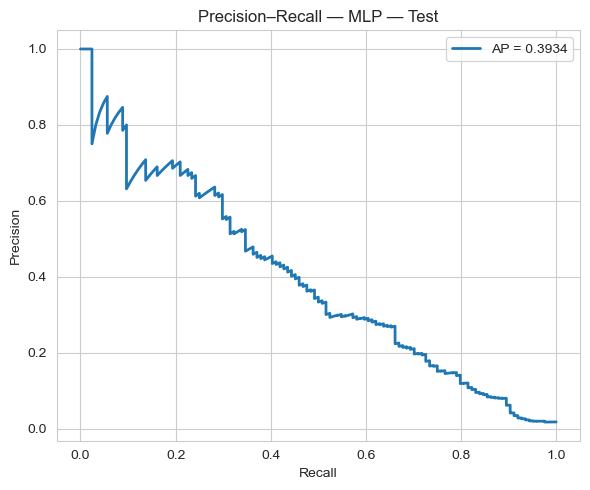

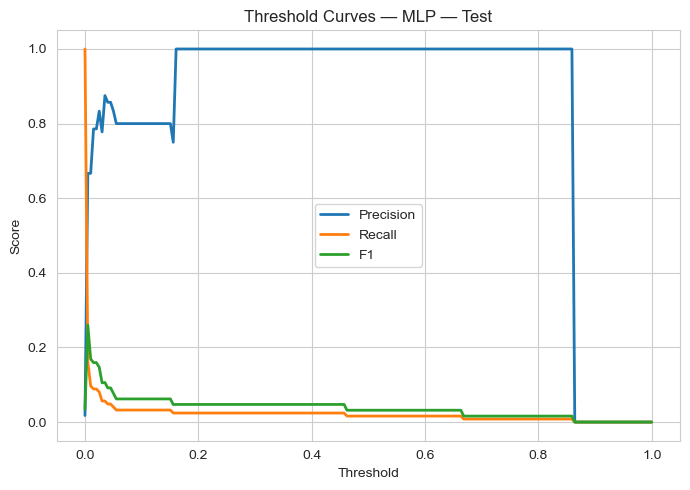

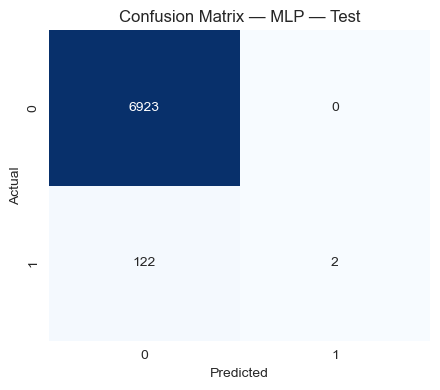

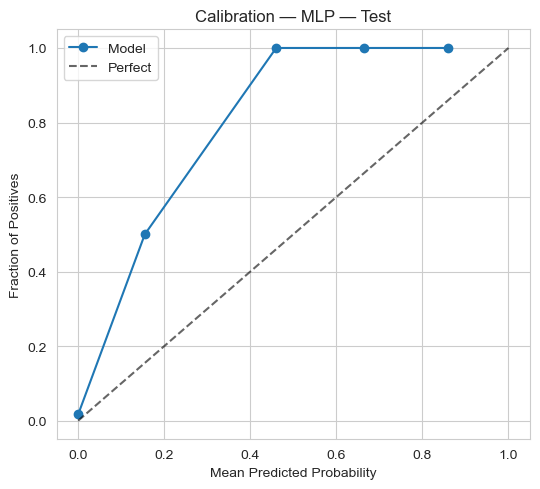


----------------------------------------
Training Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,ExtraTrees,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,MLP,0.999343,0.904762,0.422222,0.575758,0.983432,0.637896
4,LogisticRegression,0.968023,0.031294,0.977778,0.060648,0.992166,0.505406



----------------------------------------
Validation Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,RandomForest,0.999155,1.000000,0.181818,0.307692,0.860093,0.447251
1,XGBoost,0.998780,0.416667,0.454545,0.434783,0.903335,0.432687
2,ExtraTrees,0.999062,1.000000,0.090909,0.166667,0.904147,0.403019
3,MLP,0.999062,0.600000,0.272727,0.375000,0.761592,0.333511
4,LogisticRegression,0.968284,0.023324,0.727273,0.045198,0.799925,0.111519



----------------------------------------
Test Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.986519,0.837209,0.290323,0.431138,0.903507,0.458333
1,ExtraTrees,0.983113,1.000000,0.040323,0.077519,0.926286,0.399189
2,MLP,0.982688,1.000000,0.016129,0.031746,0.894670,0.393417
3,RandomForest,0.982404,0.000000,0.000000,0.000000,0.547220,0.308023
4,LogisticRegression,0.286789,0.022222,0.919355,0.043396,0.826902,0.204209


In [6]:
# ------------------------------------------------------------
# Baseline Models on Time-Based Train+Val / Test Split
# ------------------------------------------------------------
util.print_heading("Baseline Models — Time-Based Split")

results_time, train_time, val_time, test_time, scaler_time = baselines.run_baselines(
    features_trainval,
    features_test,
    target_col="Scam",
    do_full_eval=True,
    eval_split="test",
)

util.print_sub_heading("Training Metrics by Model")
display(train_time)

util.print_sub_heading("Validation Metrics by Model")
display(val_time)

util.print_sub_heading("Test Metrics by Model")
display(test_time)

### Baseline Takeaways — Time-Based Split

---

#### 1. There is still real signal, but much weaker than under random split

On the future test window (scam rate ≈ **1.8%**):

- **XGBoost** reaches **ROC AUC ≈ 0.90** and **AP ≈ 0.46**.  
- **ExtraTrees / MLP** also show non-trivial lift (AP ≈ 0.39–0.40).  

This means the engineered address features still carry **useful information** about scams even when we train on the past and test on the future.

**But:** in the random-split notebook, tuned XGBoost reached **AP ≈ 0.79** and much higher F1.  
The drop from ~0.79 → ~0.46 AP is a clear sign that **time drift hurts**.

---

#### 2. Accuracy is misleading; the real trade-offs are in precision/recall

Because the test base rate is only ~1.8%:

- A model that predicts **“no scam ever”** gets ≈**98% accuracy**.  
- RandomForest essentially does this at threshold 0.5 (Accuracy 0.98, Recall 0.00).

By contrast, LogisticRegression flips the problem:

- It catches **~92%** of scams (high recall) but with **~2% precision**, tanking accuracy to ~29%.  

**Implication:** we must judge models by **precision, recall, AP, and ROC AUC**, not raw accuracy.

---

#### 3. Tree ensembles overfit the past and generalize unevenly to the future

- On Train, all three tree models (RF, ExtraTrees, XGBoost) are essentially **perfect** (AUC/AP ≈ 1.0) — classic memorization on a rare-event task.
- On the **future** test slice:
  - **RandomForest** collapses (AUC ≈ 0.55, AP ≈ 0.31; no scams caught at 0.5).  
  - **ExtraTrees / MLP** behave as **very high-precision, very low-recall filters**.  
  - **XGBoost** degrades, but remains usable (Precision ≈ 0.84, Recall ≈ 0.29, F1 ≈ 0.43).

**Implication:** the patterns that trees learn from early scams **do not transfer uniformly** to later scams; some architectures (XGBoost) are more robust than others.

---

#### 4. XGBoost is again the best all-around baseline for the time split

Among the baselines:

- Highest **AP** on the future window (~0.46 vs base rate 0.018),  
- Balanced **precision/recall** at threshold 0.5 (≈84% precision, ≈29% recall),  
- Stable AUC between validation and test (~0.90 in both).

**Implication:** for time-aware modeling, XGBoost remains the most promising candidate, but its performance is **much less impressive** than in the random-split experiment.

---

#### 5. The gap to the random split quantifies temporal drift

Under the random address split:

- Tuned XGBoost reached **AP ≈ 0.79**, **F1 ≈ 0.72**, and could catch ~two-thirds of scams with ~80% precision.

Under the time-based split:

- Baseline XGBoost drops to **AP ≈ 0.46**, **F1 ≈ 0.43**, and only catches **~30%** of scams at similar precision.

Because the **modeling pipeline is unchanged**, this gap is strong evidence that:

> Scam patterns and base rates in this synthetic Ethereum dataset **shift over time**, so a model trained on older data cannot be assumed to perform as well on future scams as it does under a random i.i.d. split.

## 5. Hyperparameter Tuning — Time-Based Split

In the random-split experiment, we tuned the three strongest tree models  
(**RandomForest, ExtraTrees, XGBoost**) with `RandomizedSearchCV`.

Here we repeat the **same tuning pipeline on the time-based split**:

- Same models and search spaces  
- Same scoring metric (**Average Precision**)  
- Same Train/Val/Test structure

Any improvement we see here shows how much **hyperparameters alone** can help under
temporal drift, and how big the remaining gap is compared to the random split.


Hyperparameter Tuning — Time-Based Split


Train / Validation Split for Tuning

Train+Val shape: (53282, 31)
Test shape:      (7047, 31)
Train+Val positives: 56
Train+Val negatives: 53226
Test positives:       124
Test negatives:       6923

Train size: 42625
Val size:   10657
Test size:  7047

Scaling (for any scaled models, if added later)


Defining Random Search Spaces


Running RandomizedSearchCV


----------------------------------------
Tuning XGBoost
----------------------------------------

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.04159969709057025, max_depth=7, min_child_weight=7, n_estimators=421, scale_pos_weight=946.2222222222222, subsample=0.6399899663272012; total time=   1.2s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.04159969709057025, max_depth=7, min_child_weight=7, n_estimators=421, scale_pos_weight=946.222222222222

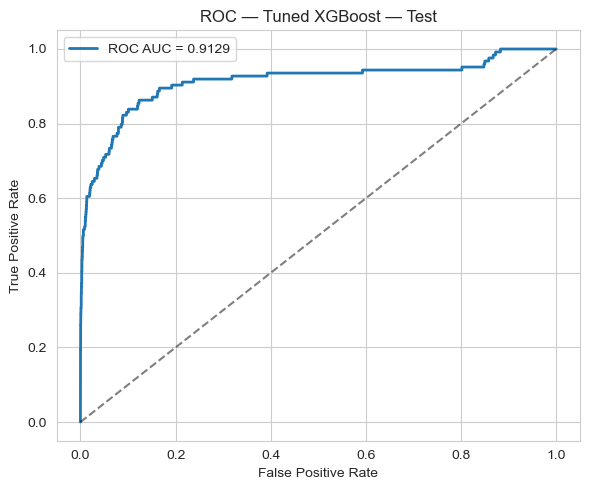

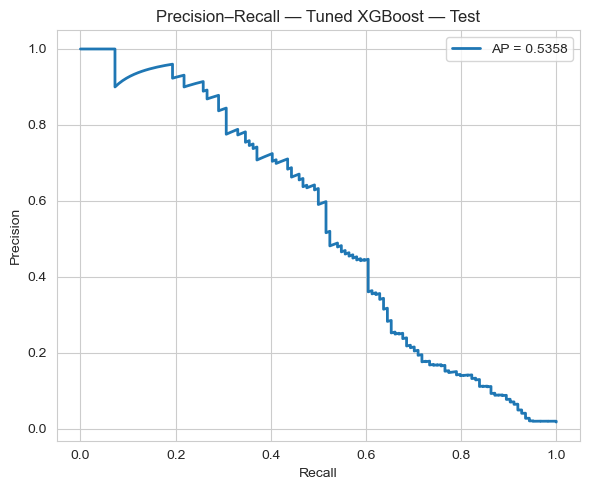

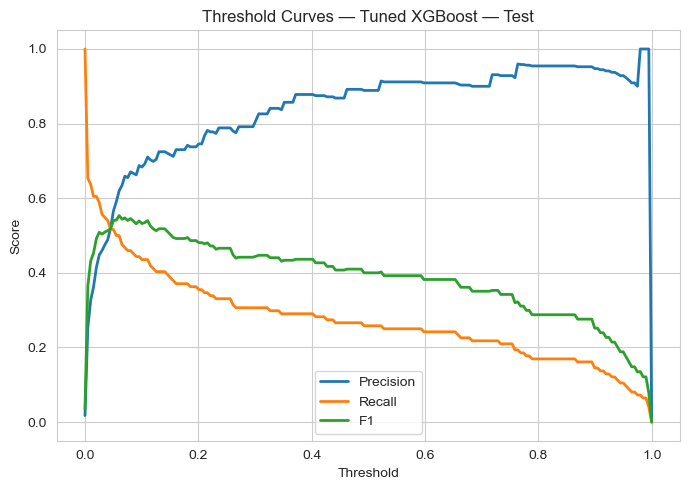

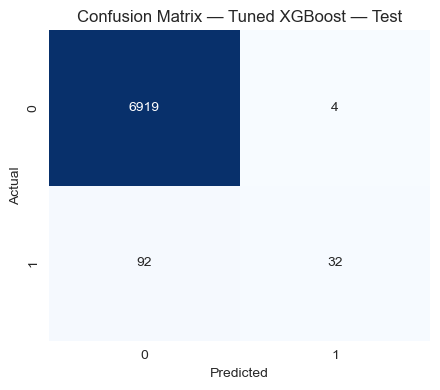

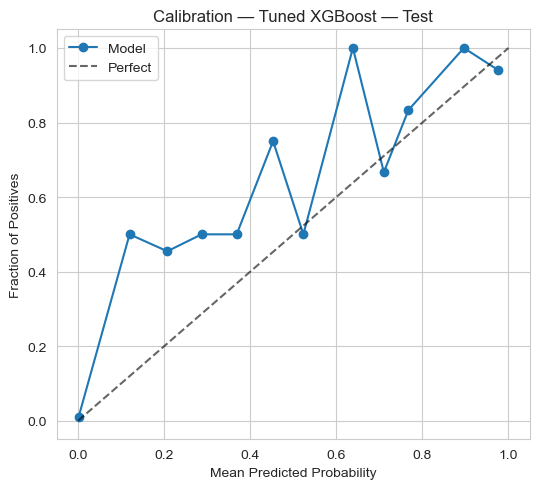


----------------------------------------
Plots for Tuned RandomForest (Test)
----------------------------------------


=== Evaluation for: Tuned RandomForest — Test ===
threshold = 0.5
Accuracy:  0.9833
Precision: 1.0000
Recall:    0.0484
F1:        0.0923
ROC AUC:   0.6507
Avg Precision (AP): 0.3945


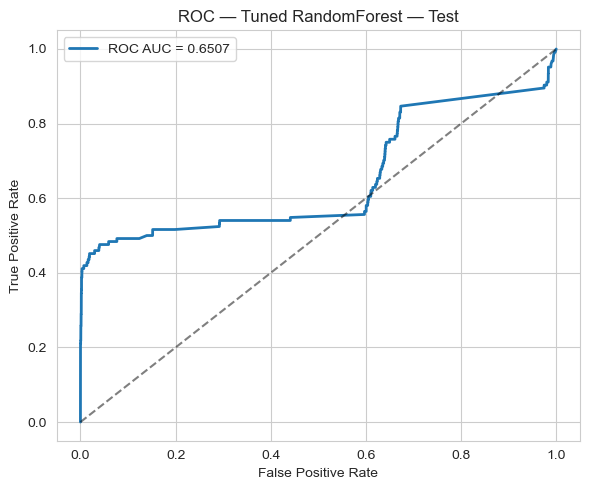

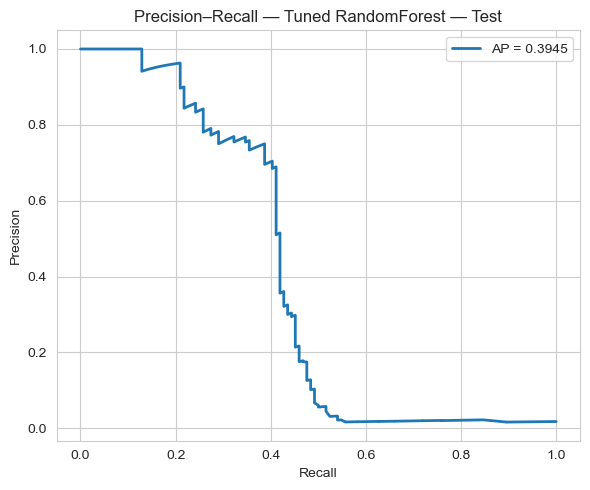

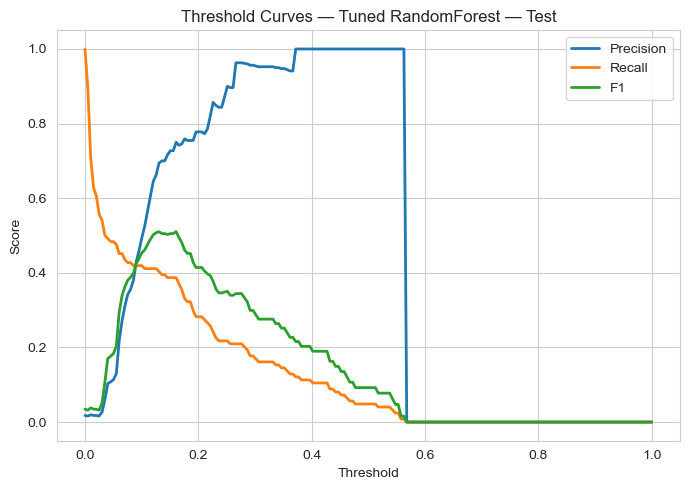

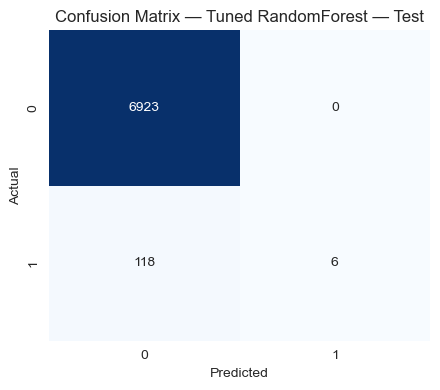

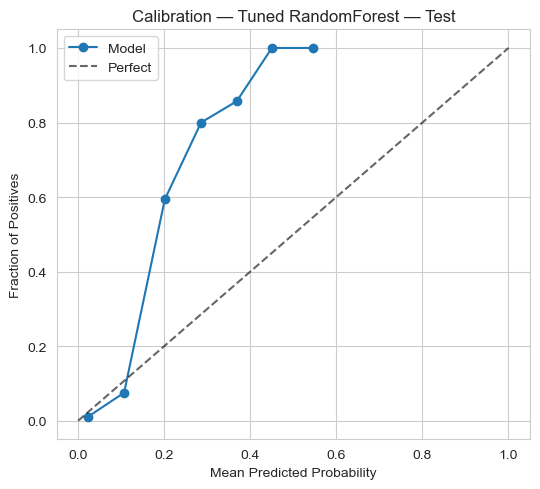


----------------------------------------
Plots for Tuned ExtraTrees (Test)
----------------------------------------


=== Evaluation for: Tuned ExtraTrees — Test ===
threshold = 0.5
Accuracy:  0.9845
Precision: 0.7027
Recall:    0.2097
F1:        0.3230
ROC AUC:   0.9099
Avg Precision (AP): 0.3938


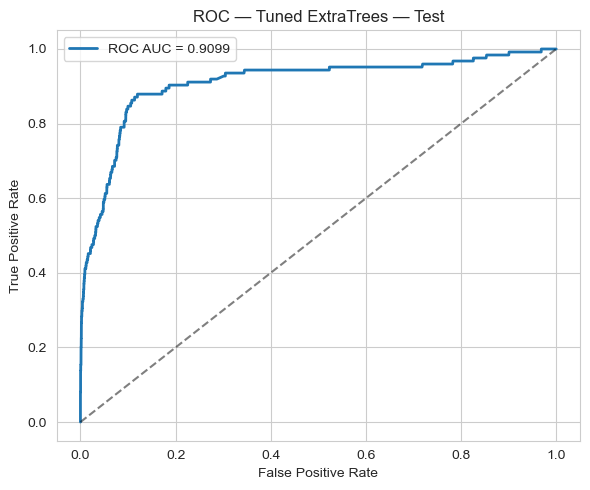

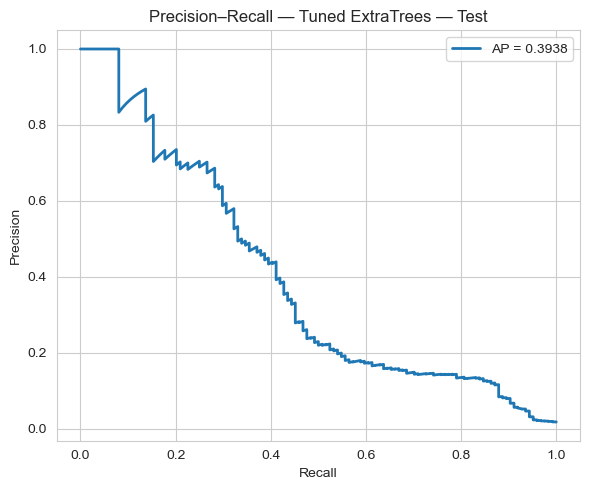

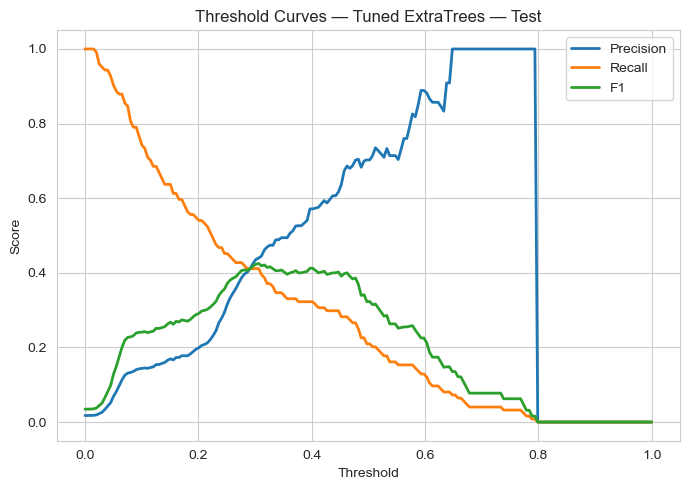

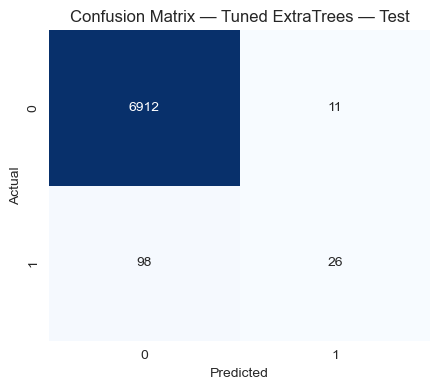

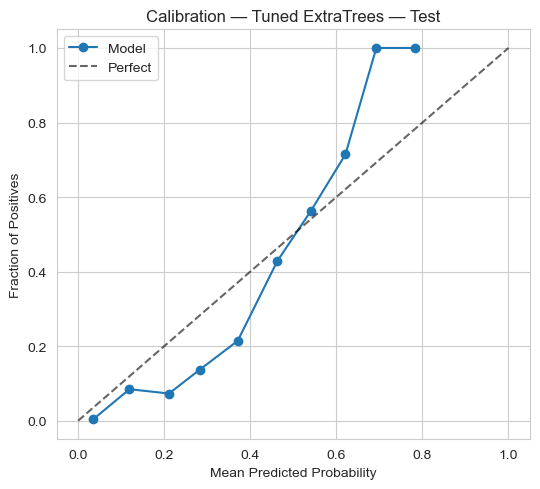


----------------------------------------
Training Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
1,ExtraTrees,0.999625,0.737705,1.0,0.849057,0.999999,0.999517
2,RandomForest,0.999977,0.978261,1.0,0.989011,0.999997,0.996930



----------------------------------------
Validation Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,RandomForest,0.999343,0.833333,0.454545,0.588235,0.852745,0.512290
1,XGBoost,0.999249,0.714286,0.454545,0.555556,0.960779,0.468490
2,ExtraTrees,0.998874,0.454545,0.454545,0.454545,0.972367,0.380819



----------------------------------------
Test Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.986377,0.888889,0.258065,0.400000,0.912888,0.535805
1,RandomForest,0.983255,1.000000,0.048387,0.092308,0.650738,0.394491
2,ExtraTrees,0.984532,0.702703,0.209677,0.322981,0.909851,0.393751


In [7]:
# ------------------------------------------------------------
# Hyperparameter tuning — tree ensembles on time-based split
#    (RandomForest, ExtraTrees, XGBoost)
# ------------------------------------------------------------
util.print_heading("Hyperparameter Tuning — Time-Based Split")

best_time, train_time_tuned, val_time_tuned, test_time_tuned, \
    search_spaces_time, scaler_time_tuned = tuning.run_tuning(
        features_trainval,
        features_test,
        target_col="Scam",
        threshold=0.5,
        do_full_eval=True,   # plot ROC / PR / calibration on chosen eval split
        eval_split="test",   # full diagnostics on the future test window
    )

util.print_sub_heading("Training Metrics by Model (Tuned)")
display(train_time_tuned)

util.print_sub_heading("Validation Metrics by Model (Tuned)")
display(val_time_tuned)

util.print_sub_heading("Test Metrics by Model (Tuned)")
display(test_time_tuned)

### Hyperparameter Tuning Takeaways — Time-Based Split

- Tuning improves XGBoost’s **Average Precision** from ~0.46 → ~0.54 and slightly boosts ROC AUC, but leaves us far below the random-split AP (~0.79).
- ExtraTrees and RandomForest improve somewhat, but XGBoost remains the only strong all-around model on the future test window.
- All tree models still nearly memorize the tiny positive class on Train; we judge them by Val/Test, where performance is limited by **temporal drift and label shift**, not by hyperparameters.
- Reusing the **same tuning pipeline** as in the random-split notebook shows that the time-based degradation is a **data problem, not a modeling bug**.

## 6. XGBoost Narrow Hyperparameter Search — Time-Based Split

In the random-split experiment, we followed broad tree-model tuning with a  
**narrow XGBoost-only search**, zooming in around the best region to check
how **robust** performance was to small hyperparameter changes.

We repeat that here on the **time-based split**, using the same narrow search
space and evaluation setup. The goal is not to find a brand-new model, but to
see:

- Whether a more regularized XGBoost can match or slightly improve the tuned model  
- How stable performance is under temporal drift when we stay in a “reasonable”
  XGBoost configuration band.


XGBoost Narrow Hyperparameter Search — Time-Based Split


XGBoost Narrow Hyperparameter Search

Train+Val shape: (53282, 31)
Test shape:      (7047, 31)
Train+Val positives: 56
Train+Val negatives: 53226
Test positives:       124
Test negatives:       6923

Running narrowed XGBoost random search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.1178392730173686, max_depth=10, min_child_weight=5, n_estimators=402, reg_alpha=0.22291637642679557, reg_lambda=0.6499623737270044, subsample=0.8377746675897602; total time=   0.7s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.1178392730173686, max_depth=10, min_child_weight=5, n_estimators=402, reg_alpha=0.22291637642679557, reg_lambda=0.6499623737270044, subsample=0.8377746675897602; total time=   0.7s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.11783927301

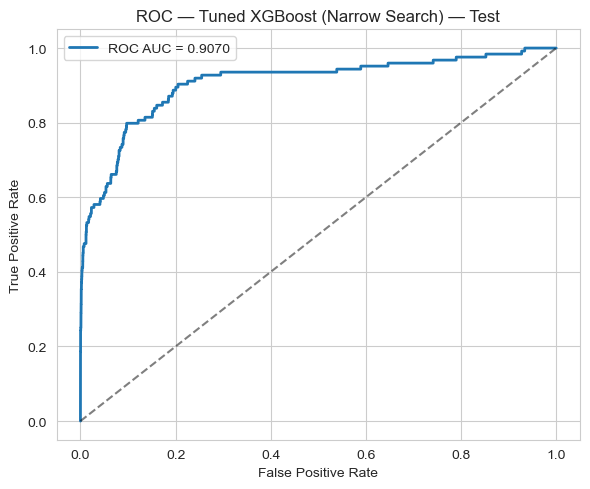

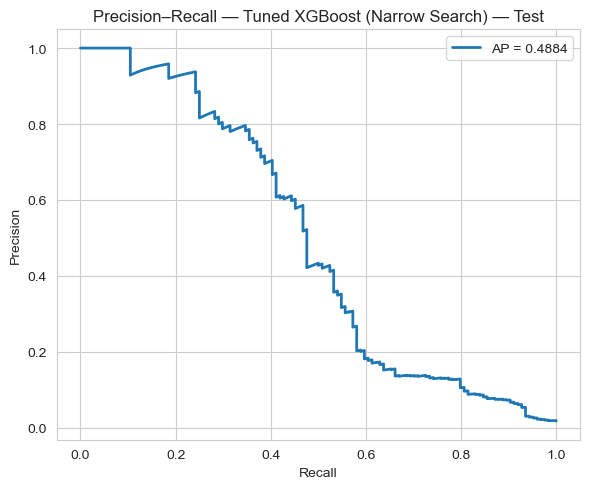

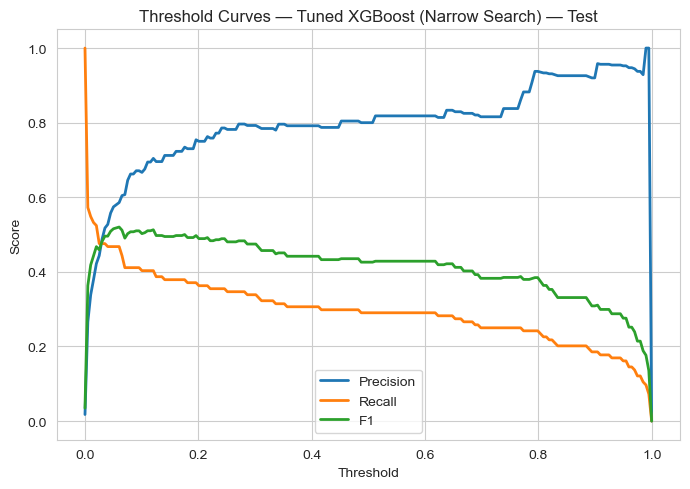

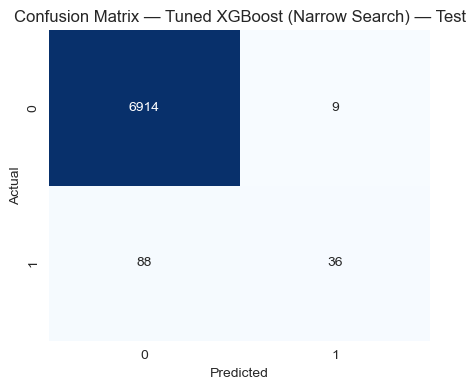

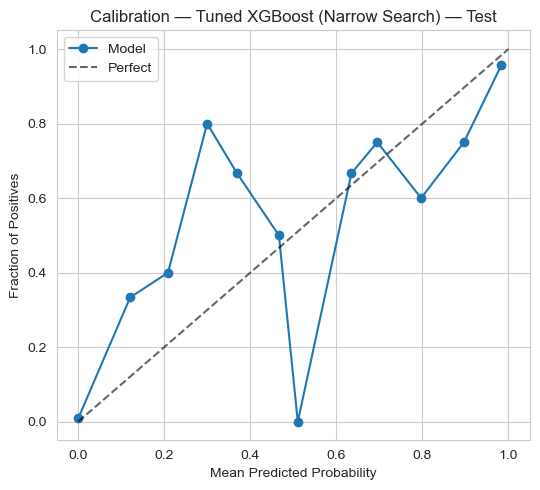


----------------------------------------
Training Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),1.0,1.0,1.0,1.0,1.0,1.0



----------------------------------------
Validation Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),0.998874,0.454545,0.454545,0.454545,0.899228,0.43647



----------------------------------------
Test Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),0.986235,0.8,0.290323,0.426036,0.906978,0.4884


In [8]:
# ------------------------------------------------------------
# XGBoost-only narrow hyperparameter search — Time-Based Split
# ------------------------------------------------------------
util.print_heading("XGBoost Narrow Hyperparameter Search — Time-Based Split")

best_xgb_time, train_xgb_narrow, val_xgb_narrow, test_xgb_narrow, \
    xgb_narrow_time_search = tuning.run_xgb_narrow(
        features_trainval,
        features_test,
        target_col="Scam",
        threshold=0.5,
        do_full_eval=True,   # full ROC/PR/threshold/calibration on chosen split
        eval_split="test",   # visualize behavior on the future test window
    )

util.print_sub_heading("Training Metrics — XGBoost (Narrow Search)")
display(train_xgb_narrow)

util.print_sub_heading("Validation Metrics — XGBoost (Narrow Search)")
display(val_xgb_narrow)

util.print_sub_heading("Test Metrics — XGBoost (Narrow Search)")
display(test_xgb_narrow)

### Key Takeaways — Narrow XGBoost Tuning (Time-Based Split)

- The **narrow-search XGBoost** lands at ROC AUC ≈ **0.91** and AP ≈ **0.49** on the
  future test window — slightly below the broader tuned XGBoost (AP ≈ **0.54**),
  with a very similar F1 score (~0.43).

- The operating point at threshold 0.5 shifts only a little:
  - Broad tuned XGBoost: Precision ≈ **0.89**, Recall ≈ **0.26**, F1 ≈ **0.40**  
  - Narrow XGBoost:      Precision ≈ **0.80**, Recall ≈ **0.29**, F1 ≈ **0.43**

- All reasonable XGBoost configurations in this “narrow” region deliver **comparable
  performance** under the time-based split. There is **no fragile, razor-thin
  setting** that suddenly recovers the random-split AP of ~0.79.

- We therefore **keep the broad tuned XGBoost** as our main time-split model and
  treat the narrow search as a **robustness check**: tuning details can move
  precision vs. recall a bit, but the overall performance ceiling is set by
  **temporal drift and changing scam patterns**, not by hyperparameters.

## 7. Best Model Threshold Tuning — Time-Based Split

We now treat the **tuned XGBoost** as a pure *ranker* and choose an operating
threshold using the **same rule** as in the random-split notebook:

> Require precision ≥ 0.75 on the validation slice, then among those
> thresholds choose the one with **maximum recall** (tie-breaker: F1).

We then lock that threshold and report final metrics on the **future test**
window. This gives an apples-to-apples comparison with the random split under
a realistic, precision-first alerting policy.

Val positives: 11 Val negatives: 10646
Test positives: 124 Test negatives: 6923

Chosen threshold (from validation): 0.59
threshold    0.590000
precision    0.833333
recall       0.454545
f1           0.588235
accuracy     0.999343
Name: 58, dtype: float64

=== Final Test Metrics at Chosen Threshold ===
threshold: 0.5900
accuracy: 0.9864
precision: 0.9118
recall: 0.2500
f1: 0.3924
roc_auc: 0.9129
avg_precision: 0.5358
base_rate: 0.0176

Confusion matrix (Test):
[[6920    3]
 [  93   31]]

=== Evaluation for: Final Tuned XGBoost — Time-Based Split (threshold search) ===
threshold = 0.59
Accuracy:  0.9864
Precision: 0.9118
Recall:    0.2500
F1:        0.3924
ROC AUC:   0.9129
Avg Precision (AP): 0.5358


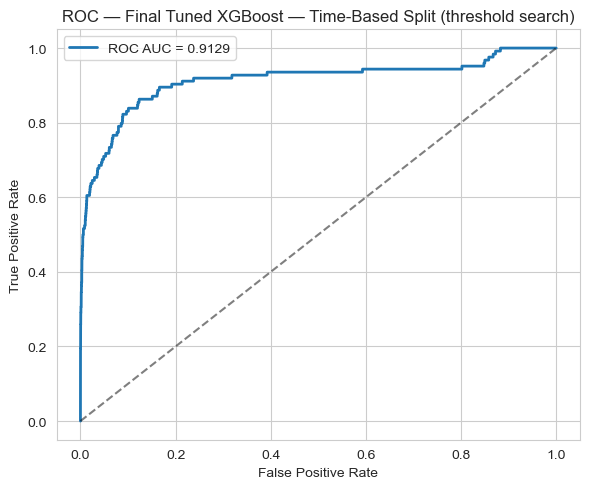

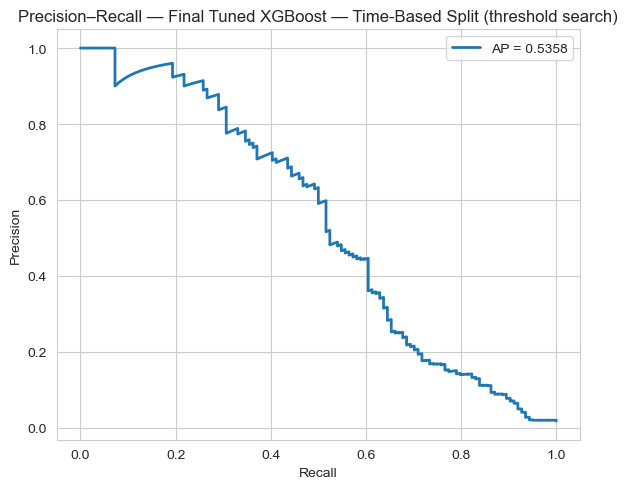

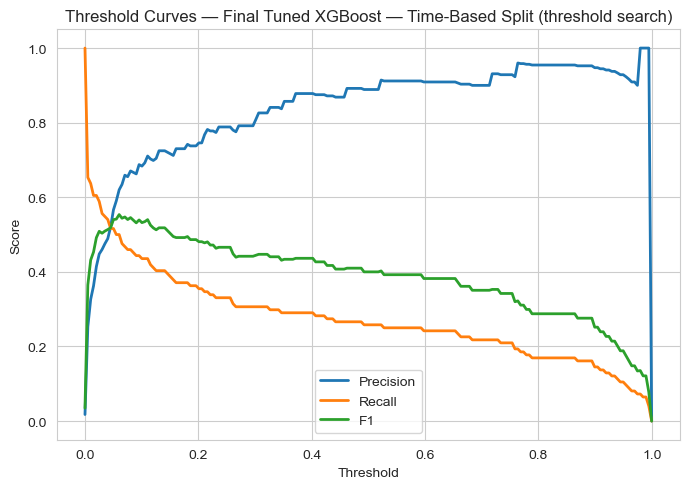

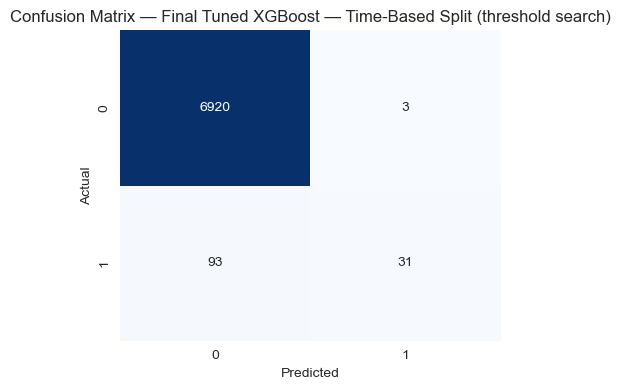

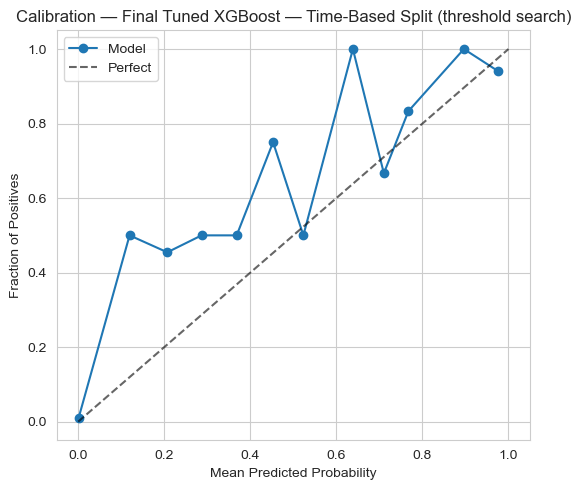

In [9]:
# ------------------------------------------------------------
# Prepare feature matrices for threshold tuning
# ------------------------------------------------------------
feature_cols = [c for c in features_trainval.columns if c != "Scam"]

# Train+Val features / labels (same ones used in tuning)
X_trainval = features_trainval[feature_cols].copy()
y_trainval = features_trainval["Scam"].astype(int).values

# Future test features / labels
X_test = features_test[feature_cols].copy()
y_test = features_test["Scam"].astype(int).values

# ------------------------------------------------------------
# Choose which tuned model to threshold
# ------------------------------------------------------------
final_model = best_time["XGBoost"]

# ------------------------------------------------------------
# Precision-first threshold tuning (same rule as random split)
#   - Sweep thresholds on validation (split from X_trainval / y_trainval)
#   - Require precision >= 0.75
#   - Among those, pick the highest-recall threshold (tie-breaker: F1)
#   - Evaluate and plot on the untouched test set
# ------------------------------------------------------------
best_threshold, val_sweep_df, test_metrics = me.precision_first_threshold_tuning(
    final_model,
    X_trainval,
    y_trainval,
    X_test,
    y_test,
    prec_min=0.75,
    name="Final Tuned XGBoost — Time-Based Split (threshold search)",
)

### Final XGBoost Model & Threshold Tuning — Time-Based Split

---

#### 1. Same precision-first rule, very different operating point

Using the tuned XGBoost as a **ranker**, we swept thresholds on the
validation slice and applied the same rule as in the random-split notebook:

> **Require precision ≥ 0.75, then maximize recall (tie-breaker: F1).**

This selected **threshold = 0.59**, where validation performance is:

- Precision ≈ **0.83**
- Recall ≈ **0.45**
- F1 ≈ **0.59**

On the **future test window** (scam base rate ≈ **1.8%**), this threshold yields:

- **Precision:** 0.91  
- **Recall:** 0.25  
- **F1:** 0.39  
- **ROC AUC:** 0.91  
- **Average Precision:** 0.54  

The confusion matrix is:

- True negatives: **6,920**  
- False positives: **3**  
- False negatives: **93**  
- True positives: **31**

So the model raises a **very small alert list** (34 addresses), and **~9 out of 10**
alerts are real scams, but it only catches about **one quarter of all scams**.

---

#### 2. Direct contrast with the random-split operating point

Under the **same precision-first rule**, the random-split tuned XGBoost achieved:

- Precision ≈ **0.79**, Recall ≈ **0.68**, F1 ≈ **0.73**, AP ≈ **0.79**.

Time-based tuning gives:

- Precision ≈ **0.91**, Recall ≈ **0.25**, F1 ≈ **0.39**, AP ≈ **0.54**.

**Implication:** when we move from a random i.i.d. split to a realistic
past→future split, the model can still produce a **high-precision triage list**, but
its ability to **cover future scams collapses**. The same pipeline that performs
extremely well under random splitting becomes a much more limited tool once
temporal drift is introduced.

---

#### 3. Interpretation for a production fraud system

- Under time-based evaluation, tuned XGBoost behaves like a
  **precision-first early warning system**:
  - Great for a **tiny, high-quality manual review queue**.
  - Not sufficient as a standalone detector if missing ~75% of scams is unacceptable.

- Together with the random-split results, this shows that:
  - The **modeling framework is sound**,  
  - The **limiting factor is temporal drift and changing scam patterns**, not
    hyperparameters or threshold choice.

## 8. Summary — What This Time-Based Split Experiment Tells Us

This notebook answers a different question from the random split:

> **How well can we detect scams when we train on earlier activity and deploy on a later time window?**

### 1. The signal survives, but it’s much weaker over time

- With a time-based past→future split, tuned XGBoost on the **future test window** reaches:
  - ROC AUC ≈ **0.91**
  - Average Precision ≈ **0.54**
- Under a random i.i.d. address split, the same feature set and pipeline reached **AP ≈ 0.79**.

**Takeaway:** the model still has real predictive power on future scams, but the
ranker is **much less informative** once we respect time.

---

### 2. Same precision rule, sharply reduced coverage of scams

Using the same precision-first threshold rule as the random-split notebook  
(precision ≥ 0.75 on validation, then maximize recall):

- **Random split (tuned XGBoost):**
  - Precision ≈ **0.79**, Recall ≈ **0.68**, F1 ≈ **0.73**
- **Time-based split (tuned XGBoost):**
  - Precision ≈ **0.91**, Recall ≈ **0.25**, F1 ≈ **0.39**

On the future test window, the model:

- Raises a **tiny alert list** (34 addresses),
- Is **right ~91% of the time** when it flags a scam,
- But misses about **3 out of 4 scams**.

**Takeaway:** under temporal drift, we can keep very high precision,  
but only by accepting **much lower recall**.

---

### 3. Hyperparameters are not the bottleneck

- We re-used the **exact same tuning pipeline** as the random-split experiment:
  - Broad RandomizedSearchCV over **RandomForest, ExtraTrees, XGBoost**.
  - A follow-up **narrow XGBoost** search.
- All reasonable XGBoost configs land in a similar band
  (AUC ≈ 0.90–0.91, AP ≈ 0.49–0.54 on the future test set).

**Takeaway:** extra tuning and alternate tree settings produce **small tweaks**,  
not a recovery of random-split performance. The ceiling is set by  
**time-based distribution shift**, not by model choice.

---

### 4. What this means for a production-style fraud system

Under a realistic past→future split, this address-level model behaves like:

- A **high-precision triage filter** (short, clean alert queue),
- Not a comprehensive “catch almost everything” detector.

To make this production-ready, we would likely need to:

- **Retrain frequently** on rolling time windows,
- Monitor **concept drift / label shift** over time,
- Combine this model with **other signals** (e.g., content, networks, external labels).

---

### 5. How it pairs with the random-split notebook

Together, the two experiments tell a coherent story:

- **Random split notebook:**  
  *Upper bound under stable conditions* — how well we can separate scam vs non-scam when past and future look statistically similar.

- **Time-based split notebook (this one):**  
  *Realistic deployment conditions* — what survives when scam behavior evolves over time.

The gap between the two is a measure of **temporal brittleness** in this synthetic
Ethereum fraud world, and a reminder that fraud models must be evaluated in the
way they’ll actually be used: **train on yesterday, score tomorrow.**